<a href="https://colab.research.google.com/github/jkeza1/facemask-classification-pipeline/blob/main/facemask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
 #INSTALL DEPENDENCIES

!pip install tensorflow
!pip install keras
!pip install matplotlib
!pip install seaborn
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install opencv-python
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow opencv-python imutils



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25855 sha256=56bba475ca6f8d7d67a85807424db89f143b96392153af326ffb2e47a4b42a23
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\31\d0\2c\87ce38f6052879e5b7b18f0f8b4a10ad2a9d210e908d449f16
Successfully built imutils


  DEPRECATION: Building 'imutils' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'imutils'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [15]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2
import imutils
from imutils import paths
import pickle
import time
import json

In [18]:
original_dataset_dir = r"C:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\Dataset"


In [19]:
folder_path = r"C:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\Dataset"

import os

for root, dirs, files in os.walk(folder_path):
    print(f"📁 {root}")
    for f in files:
        print(f"   └── {f}")


📁 C:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\Dataset
📁 C:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\Dataset\mask_weared_incorrect
   └── 1.png
   └── 10.png
   └── 100.png
   └── 1000.png
   └── 1001.png
   └── 1002.png
   └── 1003.png
   └── 1004.png
   └── 1005.png
   └── 1006.png
   └── 1007.png
   └── 1008.png
   └── 1009.png
   └── 101.png
   └── 1010.png
   └── 1011.png
   └── 1012.png
   └── 1013.png
   └── 1014.png
   └── 1015.png
   └── 1016.png
   └── 1017.png
   └── 1018.png
   └── 1019.png
   └── 102.png
   └── 1020.png
   └── 1021.png
   └── 1022.png
   └── 1023.png
   └── 1024.png
   └── 1025.png
   └── 1026.png
   └── 1027.png
   └── 1028.png
   └── 1029.png
   └── 103.png
   └── 1030.png
   └── 1031.png
   └── 1032.png
   └── 1033.png
   └── 1034.png
   └── 1035.png
   └── 1036.png
   └── 1037.png
   └── 1038.png
   └── 1039.png
   └── 104.png
   └── 1040.png
   └── 1041.png
   └── 1042.png
   └── 1043.png
   └── 1044.

In [21]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define dataset paths
original_dataset_dir = r"C:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\Dataset"
base_dir = r"C:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\Dataset_Split"

# Define classes
classes = ['mask_weared_incorrect', 'with_mask', 'without_mask']

# Create directories for split dataset
for split in ['train', 'val']:
    for class_name in classes:
        split_dir = os.path.join(base_dir, split, class_name)
        os.makedirs(split_dir, exist_ok=True)

# Collect image file paths and labels
file_paths = []
labels = []

for class_name in classes:
    class_dir = os.path.join(original_dataset_dir, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            file_paths.append(os.path.join(class_dir, fname))
            labels.append(class_name)

# Perform stratified split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Helper function to copy files
def copy_files(file_paths, labels, split):
    for path, label in zip(file_paths, labels):
        dst_dir = os.path.join(base_dir, split, label)
        shutil.copy(path, dst_dir)

# Copy the files
copy_files(train_paths, train_labels, 'train')
copy_files(val_paths, val_labels, 'val')

print("✅ Stratified splitting and copying completed.")


✅ Stratified splitting and copying completed.


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Validation generator (no augmentation, just preprocessing)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Get class names
class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)


Found 7185 images belonging to 3 classes.
Found 1797 images belonging to 3 classes.
Class names: ['mask_weared_incorrect', 'with_mask', 'without_mask']


In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Create data generators
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use local dataset path
dataset_path = r"C:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\Dataset"

# Training data generator
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation data generator
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Get class names
class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)


Found 7188 images belonging to 3 classes.
Found 1794 images belonging to 3 classes.
Class names: ['mask_weared_incorrect', 'with_mask', 'without_mask']


In [29]:
#  MODEL CREATION
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,707 (28.20 MB)

 Trainable params: 7,392,707 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10 
)


Epoch 1/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 110s 491ms/step - accuracy: 0.9275 - loss: 0.2046 - val_accuracy: 0.9464 - val_loss: 0.1541
Epoch 2/10
  1/224 ━━━━━━━━━━━━━━━━━━━━ 1:09 313ms/step - accuracy: 0.9688 - loss: 0.1612

c:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


224/224 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.9688 - loss: 0.1612 - val_accuracy: 0.9386 - val_loss: 0.1672
Epoch 3/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 95s 423ms/step - accuracy: 0.9399 - loss: 0.1658 - val_accuracy: 0.9531 - val_loss: 0.1332
Epoch 4/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9062 - loss: 0.2274 - val_accuracy: 0.9537 - val_loss: 0.1436
Epoch 5/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 107s 477ms/step - accuracy: 0.9507 - loss: 0.1439 - val_accuracy: 0.9604 - val_loss: 0.1174
Epoch 6/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.9688 - loss: 0.1386 - val_accuracy: 0.9632 - val_loss: 0.1069
Epoch 7/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 113s 503ms/step - accuracy: 0.9591 - loss: 0.1170 - val_accuracy: 0.9609 - val_loss: 0.1242
Epoch 8/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.9062 - loss: 0.2304 - val_accuracy: 0.9632 - val_loss: 0.1153
Epoch 9/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 112s 501ms/step - accuracy: 0.9653 - loss: 0.1053 - val_a

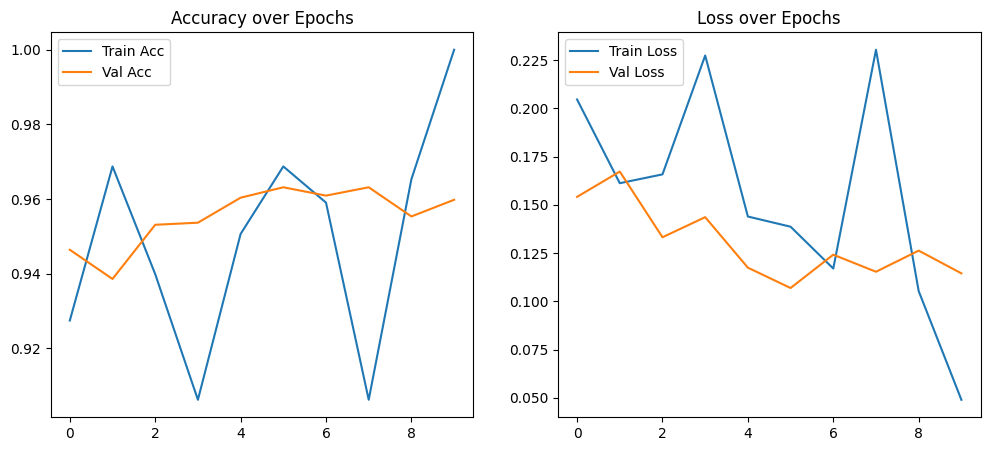

In [32]:
# MODEL EVALUATION
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Plot accuracy and loss curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy over Epochs")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.show()


57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step


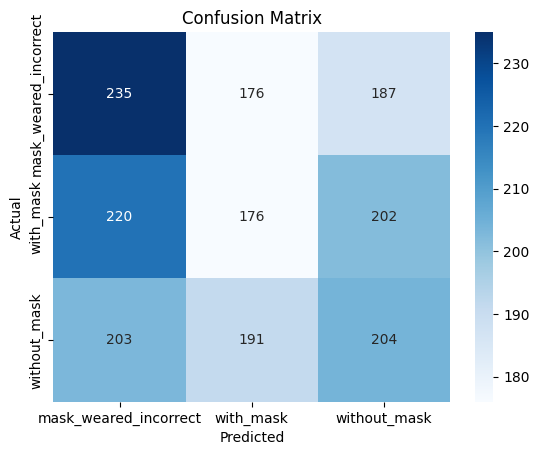

Classification Report:
                       precision    recall  f1-score   support

mask_weared_incorrect       0.36      0.39      0.37       598
            with_mask       0.32      0.29      0.31       598
         without_mask       0.34      0.34      0.34       598

             accuracy                           0.34      1794
            macro avg       0.34      0.34      0.34      1794
         weighted avg       0.34      0.34      0.34      1794



In [33]:
# Reset the generator before prediction (important)
val_generator.reset()

# Predict on validation data
Y_pred = model.predict(val_generator)

# Get predicted class indices
y_pred = np.argmax(Y_pred, axis=1)

# Get the class labels
labels = list(val_generator.class_indices.keys())

# Compute confusion matrix
conf_matrix = confusion_matrix(val_generator.classes, y_pred)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(val_generator.classes, y_pred, target_names=labels))


In [34]:
import numpy as np
print("Unique classes in val_generator:", np.unique(val_generator.classes))
print("Class indices:", val_generator.class_indices)


Unique classes in val_generator: [0 1 2]
Class indices: {'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}


In [ ]:
#  SAVE MODEL
model.save("../models/mask_detection_model.h5")
print("✅ Model saved.")


✅ Model saved.


In [42]:
import os

model_path = r"C:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\mask_detection_model.h5"
print("Does model file exist?", os.path.exists(model_path))


Does model file exist? True


In [43]:
from tensorflow.keras.models import load_model

model_path = r"C:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\mask_detection_model.h5"

try:
    model = load_model(model_path)
    print("Model loaded successfully!")
except Exception as e:
    print("Error loading model:", e)


Model loaded successfully!


In [47]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Update with the path to the image you want to predict
img_path = r"C:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\Dataset\with_mask\1.png"

# Load and resize image
img = image.load_img(img_path, target_size=(128, 128))

# Convert to array and normalize
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension


In [48]:
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Assuming you have your class labels saved or from your train_generator:
class_labels = ['mask_weared_incorrect', 'with_mask', 'without_mask']

print(f"Predicted class: {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Predicted class: with_mask


In [72]:
print("Class indices used during training:", retrain_generator.class_indices)


Class indices used during training: {'mask_weared_incorrect copy': 0, 'with_mask copy': 1, 'without_mask copy': 2}


In [55]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import tensorflow as tf

# Enable eager execution if needed (optional)
tf.config.run_functions_eagerly(True)
print("Eager execution enabled:", tf.executing_eagerly())

# Load saved model without compiling
model = load_model(r"C:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\mask_detection_model.h5", compile=False)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Path to new retraining dataset folder (update to your local folder)
new_data_path = r"C:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\DatasetNew"

# Create data generator for retraining data
retrain_datagen = ImageDataGenerator(rescale=1./255)

retrain_generator = retrain_datagen.flow_from_directory(
    new_data_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Setup early stopping callback
early_stop = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

# Retrain the model
model.fit(retrain_generator, epochs=5, callbacks=[early_stop])

# Save the retrained model
model.save(r"C:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\retrained_mask_model.h5")
print("Retrained model saved successfully.")


Eager execution enabled: True
Found 8309 images belonging to 3 classes.


c:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 236s 894ms/step - accuracy: 0.9720 - loss: 0.0945
Epoch 2/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 193s 742ms/step - accuracy: 0.9758 - loss: 0.0716
Epoch 3/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 193s 743ms/step - accuracy: 0.9809 - loss: 0.0610
Epoch 4/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 143s 547ms/step - accuracy: 0.9833 - loss: 0.0551
Epoch 5/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 154s 594ms/step - accuracy: 0.9884 - loss: 0.0346


Retrained model saved successfully.


In [56]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision:", precision_score(val_generator.classes, y_pred, average='weighted'))
print("Recall:", recall_score(val_generator.classes, y_pred, average='weighted'))
print("F1 Score:", f1_score(val_generator.classes, y_pred, average='weighted'))


Precision: 0.34176052602352064
Recall: 0.342809364548495
F1 Score: 0.3417581352712485


In [57]:
loss, accuracy = model.evaluate(retrain_generator)
print(f"Retrained model accuracy: {accuracy:.2f}")


c:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


260/260 ━━━━━━━━━━━━━━━━━━━━ 48s 182ms/step - accuracy: 0.9972 - loss: 0.0097
Retrained model accuracy: 1.00


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


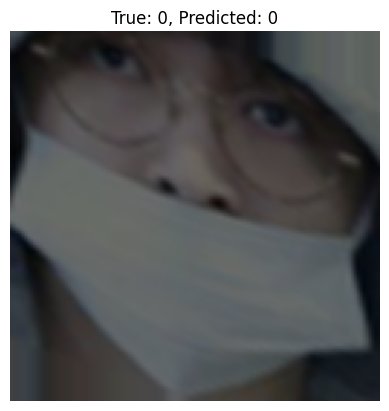

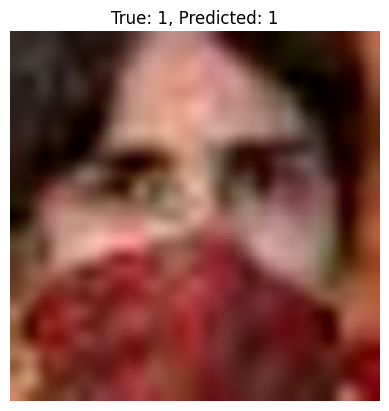

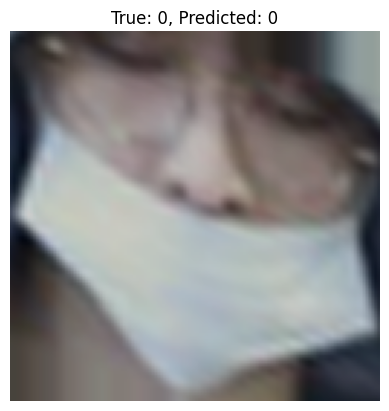

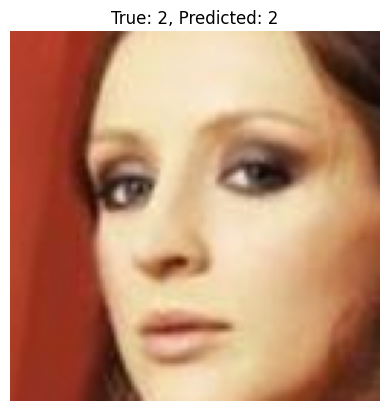

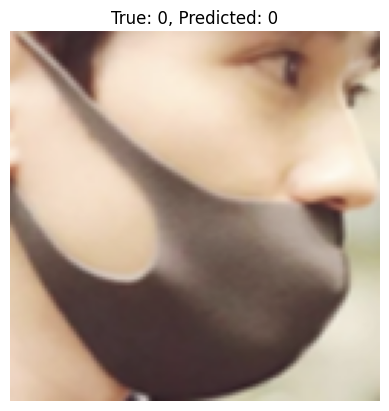

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch
images, labels = next(retrain_generator)

# Predict
preds = model.predict(images)

# Show predictions
for i in range(5):
    plt.imshow(images[i])
    plt.title(f"True: {np.argmax(labels[i])}, Predicted: {np.argmax(preds[i])}")
    plt.axis('off')
    plt.show()


In [59]:
# Retraining function with new data
def retrain_with_new_data(new_data_dir, model_path, epochs=5):
    # Load existing model
    model = tf.keras.models.load_model(model_path)

    # Prepare new data generator
    new_datagen = ImageDataGenerator(rescale=1./255)
    new_generator = new_datagen.flow_from_directory(
        new_data_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    # Unfreeze some layers for fine-tuning
    for layer in model.layers[-4:]:
        layer.trainable = True

    # Recompile with lower learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    # Retrain
    history = model.fit(
        new_generator,
        epochs=epochs,
        validation_data=val_generator
    )

    # Save retrained model
    model.save(f"{model_path}_retrained.h5")
    return history

In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Extended evaluation
def extended_evaluation(model, generator):
    generator.reset()
    y_pred = model.predict(generator)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = generator.classes

    print("Extended Evaluation Metrics:")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted')}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted')}")
    print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted')}")

    # ROC AUC for multi-class
    if len(generator.class_indices) == 2:
        from sklearn.metrics import roc_auc_score
        print(f"ROC AUC: {roc_auc_score(y_true, y_pred)}")

In [63]:
# Model and data version tracking
import datetime

def save_metadata(model, dataset_path):
    metadata = {
        'timestamp': datetime.datetime.now().isoformat(),
        'dataset_size': sum([len(files) for r, d, files in os.walk(dataset_path)]),
        'dataset_hash': hash(str(sorted(paths.list_images(dataset_path)))),
        'training_params': {
            'batch_size': BATCH_SIZE,
            'image_size': IMG_SIZE,
            'classes': list(train_generator.class_indices.keys())
        },
        'performance': {
            'val_accuracy': max(history.history['val_accuracy']),
            'val_loss': min(history.history['val_loss'])
        }
    }

    with open('model_metadata.json', 'w') as f:
        json.dump(metadata, f)

In [64]:
# Deployment-ready prediction function
def predict_image(image_path, model_path='mask_detection_model.h5'):
    # Load model and labels
    model = tf.keras.models.load_model(model_path)
    labels = {v:k for k,v in train_generator.class_indices.items()}

    # Process image
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict
    pred = model.predict(img_array)
    predicted_class = labels[np.argmax(pred)]
    confidence = np.max(pred) * 100

    return {
        'class': predicted_class,
        'confidence': float(confidence),
        'timestamp': datetime.datetime.now().isoformat()
    }

In [65]:
# Data validation checks
def validate_dataset(dataset_path):
    issues = []
    class_counts = {}

    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_dir):
            continue

        num_images = len(os.listdir(class_dir))
        class_counts[class_name] = num_images

        if num_images < 50:
            issues.append(f"Class {class_name} has only {num_images} samples (minimum 50 recommended)")

    # Check class imbalance
    if len(class_counts) > 1:
        max_count = max(class_counts.values())
        for class_name, count in class_counts.items():
            if count < max_count * 0.3:
                issues.append(f"Class {class_name} has significantly fewer samples ({count}) than others")

    return issues if issues else "Dataset validation passed"

In [66]:
# Model versioning
MODEL_VERSION = "1.0.0"
model.save(f"mask_detector_v{MODEL_VERSION}.h5")

In [67]:
# Basic data drift detection
def detect_data_drift(new_data_dir, original_stats):
    new_stats = {}
    for class_name in os.listdir(new_data_dir):
        class_dir = os.path.join(new_data_dir, class_name)
        new_stats[class_name] = len(os.listdir(class_dir))

    drift_detected = False
    for class_name in original_stats:
        if class_name not in new_stats:
            print(f"Warning: New class {class_name} detected!")
            drift_detected = True
        elif abs(original_stats[class_name] - new_stats[class_name]) > 0.3 * original_stats[class_name]:
            print(f"Warning: Significant change in class {class_name} distribution")
            drift_detected = True

    return drift_detected

In [68]:
# Performance baseline
performance_baseline = {
    'min_accuracy': 0.85,
    'max_loss': 0.5,
    'inference_time': 0.5
}

def check_performance(model, generator):
    start_time = time.time()
    loss, accuracy = model.evaluate(generator)
    inference_time = time.time() - start_time

    issues = []
    if accuracy < performance_baseline['min_accuracy']:
        issues.append(f"Low accuracy: {accuracy:.2f}")
    if loss > performance_baseline['max_loss']:
        issues.append(f"High loss: {loss:.2f}")
    if inference_time > performance_baseline['inference_time']:
        issues.append(f"Slow inference: {inference_time:.2f}s")

    return issues if issues else "Performance meets baseline"

In [69]:
def retrain_with_new_data(new_data_dir, model_path):
    # Validate new data first
    issues = validate_dataset(new_data_dir)
    if isinstance(issues, list):
        print("Validation issues:", issues)
        return None

    # Versioning
    version = len(os.listdir("models")) + 1
    new_model_path = f"models/v{version}.h5"

    # Retrain
    history = model.fit(...)

    # Validate performance
    if history.history['val_accuracy'][-1] < 0.7:
        print("Retraining failed - accuracy too low")
        return None

    model.save(new_model_path)
    save_metadata(model, new_data_dir)
    return history

57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 329ms/step


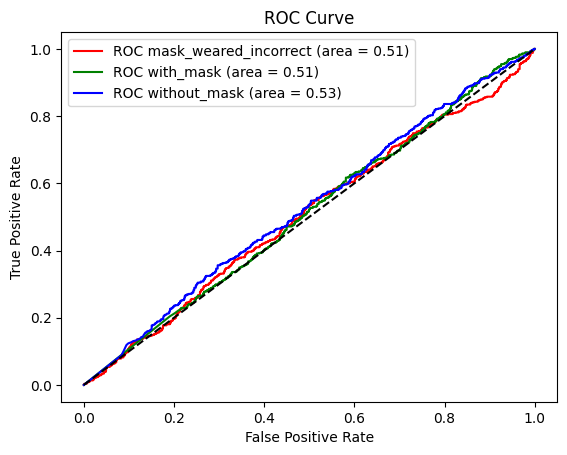

In [71]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# ROC Curve for multi-class
fpr = dict()
tpr = dict()
roc_auc = dict()
import numpy as np

# Get the number of batches
val_steps = val_generator.samples // val_generator.batch_size + 1

# Extract predictions and true labels
y_pred = model.predict(val_generator, steps=val_steps)
y_test = val_generator.classes
y_test = np.eye(len(class_names))[y_test]  # One-hot encode the labels


for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = cycle(['red', 'green', 'blue'])
for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'ROC {class_names[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()